In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA, PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedKFold, cross_validate, StratifiedKFold, StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import operator
import time
import os
from random import shuffle

import random
from tqdm import trange
import PIL.Image as Image
from IPython import display

import warnings
warnings.simplefilter(action='ignore')

RANDOM_STATE = 42
%matplotlib inline

In [66]:
data = pd.read_csv('EyeMovementsGlaucomaDataset/Data/Gaze/Processed/Control/C002.csv', header = 1
                  ).rename(index=str, columns={'Saccade': 'Tracking type'})#.drop(0)
data['Duration'] = data['Duration'] - 1
data = data.replace(".", np.nan)

data["Start X"] = pd.to_numeric(data["Start X"])
data["Start Y"] = pd.to_numeric(data["Start Y"])
data['Start X'].min()
data.head(4)

,Tracking type,Trial Name,Eye,Start Time,End Time,Duration,Start X,Start Y,End X,End Y,Amplitude,Peak Velocity
0,Fixation,DadsArmy,L,1589991,1590718,727,772.7,575.1,797.0,NaN,NaN,NaN
1,Saccade,DadsArmy,L,1590719,1590756,37,770.1,583.3,735.1,472.1,2.85,186.0
2,Fixation,DadsArmy,L,1590757,1591033,276,732.2,486.0,786.0,NaN,NaN,NaN
3,Saccade,DadsArmy,L,1591034,1591055,21,733.4,482.8,643.2,460.1,2.28,196.0


In [67]:
path = 'EyeMovementsGlaucomaDataset/Data/Clinical/ParticipantDetails.csv'
clinic = pd.read_csv(path)
clinic = clinic.sort_values(by=['ID'])
clinic = clinic.reset_index(drop = True)

In [68]:
path = 'EyeMovementsGlaucomaDataset/Data/Gaze/Processed/Control'
control_path = path 
files = [f for f in os.listdir(control_path) if f.endswith('.csv')]
dataset = clinic
files.sort()

In [69]:
path = 'EyeMovementsGlaucomaDataset/Data/Gaze/Processed/Glaucoma'
control_path = path 
files_1 = [f for f in os.listdir(control_path) if f.endswith('.csv')]
dataset = clinic
files = files + files_1
shuffle(files)

In [70]:
def make_hist_pupil(data,bins, min_diff):
    data = data.dropna()
    maximum = data['Pupil Area'].max()
    data['Pupil Area'] = data['Pupil Area'] / maximum
    
    data_video_DA = data.loc[data['Trial Name'] == 'DadsArmy']
    data_video_DA.set_index(np.arange(data_video_DA.shape[0]))
    
    data_video_HB = data.loc[data['Trial Name'] == 'HistoryBoys']
    data_video_HB.set_index(np.arange(data_video_HB.shape[0]))
    
    data_video_SC = data.loc[data['Trial Name'] == 'SkiCross']
    data_video_SC.set_index(np.arange(data_video_SC.shape[0]))
    
    pupil_hist_DA = np.zeros(bins)
    pupil_hist_HB = np.zeros(bins)
    pupil_hist_SC = np.zeros(bins)
    
    for i in range(data_video_DA.shape[0]):
        if data_video_DA['Pupil Area'].iloc[i] > min_diff:
            pupil_hist_DA[int((data_video_DA['Pupil Area'].iloc[i] - min_diff)*(bins - 1)/(1 - min_diff))] += 1
        
    for i in range(data_video_HB.shape[0]):
        if data_video_HB['Pupil Area'].iloc[i] > min_diff:
            pupil_hist_HB[int((data_video_HB['Pupil Area'].iloc[i] - min_diff)*(bins - 1)/(1 - min_diff))] += 1        
    
    for i in range(data_video_SC.shape[0]):
        if data_video_SC['Pupil Area'].iloc[i] > min_diff:
            pupil_hist_SC[int((data_video_SC['Pupil Area'].iloc[i] - min_diff)*(bins - 1)/(1 - min_diff))] += 1    
    
    return pupil_hist_DA/data_video_DA.shape[0], pupil_hist_HB/data_video_HB.shape[0], pupil_hist_SC/data_video_SC.shape[0]

In [71]:
def make_picture(data, min_saccade, size): # drop one video 
    data = data.dropna()
    data['delta X'] = (size - 1) * data['delta X'] / max(data['delta X'].max(), - data['delta X'].min())
    data['delta Y'] = (size - 1) * data['delta Y'] / max(data['delta Y'].max(), - data['delta Y'].min())    
    
    data_video_DA = data.loc[data['Trial Name'] == 'DadsArmy']
    data_video_DA.set_index(np.arange(data_video_DA.shape[0]))
    
    data_video_HB = data.loc[data['Trial Name'] == 'HistoryBoys']
    data_video_HB.set_index(np.arange(data_video_HB.shape[0]))
    
    data_video_SC = data.loc[data['Trial Name'] == 'SkiCross']
    data_video_SC.set_index(np.arange(data_video_SC.shape[0]))

    picture_DA = 255* np.ones((2*size,2*size))
    picture_HB = 255* np.ones((2*size,2*size))
    picture_SC = 255* np.ones((2*size,2*size))
    
    for i in range(data_video_DA.shape[0]):
        if np.sqrt((data_video_DA['delta X'].iloc[i])**2 + (data_video_DA['delta Y'].iloc[i])**2) > min_saccade:
            picture_DA[size + int(data_video_DA['delta X'].iloc[i]), size + int(data_video_DA['delta Y'].iloc[i]) ] = 0 

    for i in range(data_video_HB.shape[0]):
        if np.sqrt((data_video_HB['delta X'].iloc[i])**2 + (data_video_HB['delta Y'].iloc[i])**2) > min_saccade:
            picture_HB[size + int(data_video_HB['delta X'].iloc[i]), size + int(data_video_HB['delta Y'].iloc[i]) ] = 0 

    for i in range(data_video_SC.shape[0]):
        if np.sqrt((data_video_SC['delta X'].iloc[i])**2 + (data_video_SC['delta Y'].iloc[i])**2) > min_saccade:
            picture_SC[size + int(data_video_SC['delta X'].iloc[i]), size + int(data_video_SC['delta Y'].iloc[i]) ] = 0 
    
    return picture_DA/data_video_DA.shape[0], picture_HB/data_video_HB.shape[0], picture_SC/data_video_SC.shape[0]

In [72]:
def fix_sac_sep_clean(tempdata):
    tempdata = tempdata.replace(".", np.nan)
    tempdata['Duration'] = tempdata['Duration'] - 1
    tempdata["Start X"] = pd.to_numeric(tempdata["Start X"])
    tempdata["Start Y"] = pd.to_numeric(tempdata["Start Y"])
    tempdata["End X"] = pd.to_numeric(tempdata["End X"])
    tempdata["End Y"] = pd.to_numeric(tempdata["End Y"])

    tempdata_suc = pd.DataFrame(tempdata.dropna().loc[tempdata['Tracking type'] == 'Saccade' ], columns=tempdata.columns)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Amplitude'] > 1000].index) # drop bad values
    tempdata_suc.index = np.arange(tempdata_suc.shape[0])
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Start X'] > 1600].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['End X'] > 1600].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Start Y'] > 1200].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['End Y'] > 1200].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Start X'] < 1 ].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['End X'] < 1].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Start Y'] < 1].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['End Y'] < 1].index)

    tempdata_fix = pd.DataFrame(tempdata.loc[tempdata['Tracking type'] == 'Fixation' ].values[:,:9], columns=[
        'Fixation', 'Trial Name', 'Eye', 'Start Time', 'End Time', 'Duration','X', 'Y', 'Pupil Area'])
    tempdata_fix['Start Time'] = pd.to_numeric(tempdata_fix['Start Time'])
    tempdata_fix['End Time'] = pd.to_numeric(tempdata_fix['Start Time'])
    tempdata_fix['Duration'] = pd.to_numeric(tempdata_fix['Duration'])
    tempdata_fix['X'] = pd.to_numeric(tempdata_fix['X'])
    tempdata_fix['Y'] = pd.to_numeric(tempdata_fix['Y'])
    tempdata_fix['Pupil Area'] = pd.to_numeric(tempdata_fix['Pupil Area'])
    tempdata_fix.index = np.arange(tempdata_fix.shape[0])
    tempdata_fix = tempdata_fix.drop(tempdata_fix.loc[tempdata_fix['X'] > 1600].index)
    tempdata_fix = tempdata_fix.drop(tempdata_fix.loc[tempdata_fix['Y'] > 1200].index)
    tempdata_fix = tempdata_fix.drop(tempdata_fix.loc[tempdata_fix['X'] < 1].index)
    tempdata_fix = tempdata_fix.drop(tempdata_fix.loc[tempdata_fix['Y'] < 1].index)
    return tempdata_fix, tempdata_suc

In [73]:
features = ['Number of fix points per DadsArmy',
       'Number of sacs pers DadsArmy', 'Mean fix duration per DadsArmy',
       'Mean sac duration per DadsArmy', 'Mean Amplitude per DadsArmy',
       'Mean Peak Velocity per DadsArmy',
       'Fixatoin Trajectory Length DadsArmy',
       'Number of fix points per HistoryBoys',
       'Number of sacs pers HistoryBoys', 'Mean fix duration per HistoryBoys',
       'Mean sac duration per HistoryBoys', 'Mean Amplitude per HistoryBoys',
       'Mean Peak Velocity per HistoryBoys',
       'Fixatoin Trajectory Length HistoryBoys',
       'Number of fix points per SkiCross', 'Number of sacs pers SkiCross',
       'Mean fix duration per SkiCross', 'Mean sac duration per SkiCross',
       'Mean Amplitude per SkiCross', 'Mean Peak Velocity per SkiCross',
       'Fixatoin Trajectory Length SkiCross']

def make_dataset(files, features, path_read, path_write):
    dataset_DA = pd.DataFrame(np.zeros((len(files),len(features)//3)), columns = features[:len(features)//3])
    dataset_HB = pd.DataFrame(np.zeros((len(files),len(features)//3)), columns = features[len(features)//3:2*len(features)//3])
    dataset_SC = pd.DataFrame(np.zeros((len(files),len(features)//3)), columns = features[2*len(features)//3:])
    targets = []
    for index, f in enumerate(files): 
        tempdata = pd.read_csv(path_read + '/' + f, header = 1).rename(index=str, columns={'Saccade': 'Tracking type'})
        tempdata_fix, tempdata_suc = fix_sac_sep_clean(tempdata)
        # generating features from inner dataset (timeserias to features)

        data_ov_fix = tempdata_fix.loc[tempdata_fix['Trial Name'] == 'DadsArmy']
        data_ov_suc = tempdata_suc.loc[tempdata_suc['Trial Name'] == 'DadsArmy']

        dataset_DA['Number of fix points per DadsArmy'].iloc[index] = data_ov_fix.shape[0]
        dataset_DA['Number of sacs pers DadsArmy'].iloc[index] = data_ov_suc.shape[0]
        dataset_DA['Mean fix duration per DadsArmy'].iloc[index] = data_ov_fix['Duration'].mean()
        dataset_DA['Mean sac duration per DadsArmy'].iloc[index] = data_ov_suc['Duration'].mean()
        dataset_DA['Mean Amplitude per DadsArmy'].iloc[index] = data_ov_suc['Amplitude'].mean()
        dataset_DA['Mean Peak Velocity per DadsArmy'].iloc[index] = data_ov_suc['Peak Velocity'].mean()
        dataset_DA['Fixatoin Trajectory Length DadsArmy'].iloc[index] = np.sqrt((data_ov_fix['X'].values[1:] - data_ov_fix['X'].values[0:-1])**2 +\
        (data_ov_fix['Y'].values[1:] - data_ov_fix['Y'].values[:-1])**2).sum()

        data_ov_fix = tempdata_fix.loc[tempdata_fix['Trial Name'] == 'HistoryBoys']
        data_ov_suc = tempdata_suc.loc[tempdata_suc['Trial Name'] == 'HistoryBoys']

        dataset_HB['Number of fix points per HistoryBoys'].iloc[index] = data_ov_fix.shape[0]
        dataset_HB['Number of sacs pers HistoryBoys'].iloc[index] = data_ov_suc.shape[0]
        dataset_HB['Mean fix duration per HistoryBoys'].iloc[index] = data_ov_fix['Duration'].mean()
        dataset_HB['Mean sac duration per HistoryBoys'].iloc[index] = data_ov_suc['Duration'].mean()
        dataset_HB['Mean Amplitude per HistoryBoys'].iloc[index] = data_ov_suc['Amplitude'].mean()
        dataset_HB['Mean Peak Velocity per HistoryBoys'].iloc[index] = data_ov_suc['Peak Velocity'].mean()
        dataset_HB['Fixatoin Trajectory Length HistoryBoys'].iloc[index] = np.sqrt((data_ov_fix['X'].values[1:] - data_ov_fix['X'].values[0:-1])**2 +\
        (data_ov_fix['Y'].values[1:] - data_ov_fix['Y'].values[:-1])**2).sum()

        data_ov_fix = tempdata_fix.loc[tempdata_fix['Trial Name'] == 'SkiCross']
        data_ov_suc = tempdata_suc.loc[tempdata_suc['Trial Name'] == 'SkiCross']

        dataset_SC['Number of fix points per SkiCross'].iloc[index] = data_ov_fix.shape[0]
        dataset_SC['Number of sacs pers SkiCross'].iloc[index] = data_ov_suc.shape[0]
        dataset_SC['Mean fix duration per SkiCross'].iloc[index] = data_ov_fix['Duration'].mean()
        dataset_SC['Mean sac duration per SkiCross'].iloc[index] = data_ov_suc['Duration'].mean()
        dataset_SC['Mean Amplitude per SkiCross'].iloc[index] = data_ov_suc['Amplitude'].mean()
        dataset_SC['Mean Peak Velocity per SkiCross'].iloc[index] = data_ov_suc['Peak Velocity'].mean()
        dataset_SC['Fixatoin Trajectory Length SkiCross'].iloc[index] = np.sqrt((data_ov_fix['X'].values[1:] - data_ov_fix['X'].values[0:-1])**2 +\
        (data_ov_fix['Y'].values[1:] - data_ov_fix['Y'].values[:-1])**2).sum()
        
        # relative saccade and diff of pupil size
        map_suc = np.zeros((tempdata_suc.shape[0],2))
        pupil_delta = np.zeros(tempdata_fix.shape[0])
        map_suc[:,0] = tempdata_suc['Start X'].values - tempdata_suc['End X'].values
        map_suc[:,1] = tempdata_suc['Start Y'].values - tempdata_suc['End Y'].values
        pupil_delta = np.abs(tempdata_fix['Pupil Area'].values[:-1] - tempdata_fix['Pupil Area'].values[1:])
        data_suc = pd.concat([tempdata_suc['Trial Name'].iloc[:-1], pd.DataFrame(
            map_suc, columns=['delta X', 'delta Y'], index = np.arange(map_suc.shape[0]))], axis=1)
        
        data_pupil = pd.concat([tempdata_fix['Trial Name'].iloc[:-1], pd.DataFrame(
            pupil_delta, columns = ['Pupil Area'])],axis = 1)
        data_pupil = data_pupil.dropna()
        data_suc = data_suc.dropna()
        data_suc.to_csv(path_write + '_suc_delta_' + f)
        data_pupil.to_csv(path_write + '_pupil_delta_' + f)            
        if f[0] == 'C':
            targets.append(0)
        else:
            targets.append(1)
    return dataset_DA, dataset_HB, dataset_SC, targets

In [74]:
def make_density_map(data, file=None, verbose=False, warnings=True):
    data_copy = data.dropna()
    tv_diag = 54
    tv_height = np.sqrt(tv_diag**2*9/25)/2
    tv_width = np.sqrt(tv_diag**2*16/25)/2
    view_dist = 60
    angle_full_width_rad = np.arctan(tv_width/view_dist)
    angle_full_height_rad = np.arctan(tv_height/view_dist)
    angle_part_width_degr = 17.3
    angle_part_height_degr = 10.6
    max_width_angle_deg = 12
    max_height_angle_deg = 10
    min_width_angle_deg = -12
    min_height_angle_deg = -10
    max_width_angle_rad = max_width_angle_deg * np.pi / 180
    max_height_angle_rad = max_height_angle_deg * np.pi / 180
    max_width = view_dist * np.tan(max_width_angle_rad)
    max_height = view_dist * np.tan(max_height_angle_rad)
    pixel_size = 2*tv_height/1200
    if verbose:
        print('max_width = {:.3} sm \nmax_height = {:.3} sm'.format(max_width, max_height))
        print('pixel_size = {:.3} sm'.format(pixel_size))
        
    density_map_DA = np.zeros((max_height_angle_deg, max_width_angle_deg))
    density_map_HB = np.zeros((max_height_angle_deg, max_width_angle_deg))
    density_map_SC = np.zeros((max_height_angle_deg, max_width_angle_deg))
    
    max_view_width = max_width/pixel_size
    min_view_width = -max_width/pixel_size
    max_view_height = max_height/pixel_size
    min_view_height = -max_height/pixel_size
    if verbose:
        print('max_view_width = {:.3}'.format(max_view_width))
        print('min_view_width = {:.3}'.format(min_view_width))
        print('max_view_height = {:.3}'.format(max_view_height))
        print('min_view_height = {:.3}'.format(min_view_height))
    for idx in range(data_copy.shape[0]):
        delta_x = data_copy['delta X'].iloc[idx]
        delta_x_rad = np.arctan(delta_x * pixel_size / view_dist)
        delta_x_rad = delta_x_rad if delta_x >= 0 else delta_x_rad
        delta_x_deg = delta_x_rad * 180/np.pi
        delta_y = data_copy['delta Y'].iloc[idx]
        delta_y_rad = np.arctan(delta_y * pixel_size / view_dist)
        delta_y_rad = delta_y_rad if delta_y >= 0 else delta_y_rad
        delta_y_deg = delta_y_rad * 180/np.pi
      
        if (delta_x_deg >= min_width_angle_deg and delta_x_deg <= -2
           ) and (delta_y_deg <= max_height_angle_deg and delta_y_deg >= 2):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) +5, int(delta_x_deg//2) +6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) +5, int(delta_x_deg//2) +6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) +5, int(delta_x_deg//2) +6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
        if (delta_x_deg >= -2 and delta_x_deg <= 2
           ) and (delta_y_deg <= max_height_angle_deg and delta_y_deg >= 2):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
        if (delta_x_deg >= 2 and delta_x_deg <= max_width_angle_deg
           ) and (delta_y_deg <= max_height_angle_deg and delta_y_deg >= 2):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
        if (delta_x_deg >= min_width_angle_deg and delta_x_deg <= -2
           ) and (delta_y_deg <= 2 and delta_y_deg >= -2):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
        if (delta_x_deg >= 2 and delta_x_deg <= max_width_angle_deg
           ) and (delta_y_deg <= 2 and delta_y_deg >= -2):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
        if (delta_x_deg >= min_width_angle_deg and delta_x_deg <= -2
           ) and (delta_y_deg <= -2 and delta_y_deg >= min_height_angle_deg):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
        if (delta_x_deg >= -2 and delta_x_deg <= 2
           ) and (delta_y_deg <= -2 and delta_y_deg >= min_height_angle_deg):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
        if (delta_x_deg >= 2 and delta_x_deg <= max_width_angle_deg
           ) and (delta_y_deg <= -2 and delta_y_deg >= min_height_angle_deg):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
                    
    if file in ['C003.csv', 'C023.csv', 'C030.csv', 'C031.csv', 'G010.csv', 'G013.csv', 
                'G017.csv', 'G024.csv']:
        density_map_DA = np.zeros((max_height_angle_deg, max_width_angle_deg))
        density_map_DA[0, 0] = 10000
    if file in ['C023.csv', 'C027.csv', 'C030.csv', 'G010.csv', 'G024.csv', 'G026.csv',
                'G028.csv', 'G031.csv', 'G032.csv', 'G033.csv', 'G035.csv', 'G037.csv']:
        density_map_HB = np.zeros((max_height_angle_deg, max_width_angle_deg))
        density_map_HB[0, 0] = 10000
    if file in ['C026.csv', 'C027.csv', 'C032.csv', 'G001.csv', 'G010.csv', 'G024.csv',
            'G026.csv', 'G031.csv', 'G036.csv']:
        density_map_SC = np.zeros((max_height_angle_deg, max_width_angle_deg))
        density_map_SC[0, 0] = 10000
        
    return density_map_DA, density_map_HB, density_map_SC

In [75]:
def make_saccades_picture(data, trial_name='DadsArmy', save_pic=False, pic_title=None):
    data_copy = data.dropna()
    sac_coords = np.zeros((2, data_copy.shape[0]))
    for idx in range(data_copy.shape[0]):
        if data_copy['Trial Name'].iloc[idx] == trial_name:
            sac_coords[0, idx] = data_copy['delta X'].iloc[idx]
            sac_coords[1, idx] = data_copy['delta Y'].iloc[idx]
    plt.figure(figsize=(15, 10))
    for idx in range(sac_coords.shape[1]):
        plt.plot([0, sac_coords[0, idx]], [0, sac_coords[1, idx]])
    plt.xticks(())
    plt.yticks(())
    if save_pic:
        if pic_title is not None:
            plt.title(pic_title)
            plt.savefig('Saccade_coordinates_' + pic_title + '.png')
        else:
            plt.savefig('Saccade_coordinates.png')
    return sac_coords

In [76]:
# main func 
clinic_path = 'EyeMovementsGlaucomaDataset/Data/Clinical/ParticipantDetails.csv'
clinic = pd.read_csv(clinic_path)
clinic = clinic.sort_values(by=['ID'])
clinic = clinic.reset_index(drop = True)
clinic = clinic.drop(['Left MD','Right MD'], axis=1)

path = 'EyeMovementsGlaucomaDataset/Data/Gaze/Processed/Control'
control_path = path 
files = [f for f in os.listdir(control_path) if f.endswith('.csv')]
dataset = clinic
files.sort()
# Bad samples: lacking data
del files[31+10]
del files[31+24-1]

path_read = path
path_write = 'EyeMovementsGlaucomaDataset/'

dataset_DA, dataset_HB, dataset_SC, targets_d = make_dataset(files, features, path_read, path_write)
pictures_DA = []
pictures_HB = []
pictures_SC = []
den_maps_DA = []
den_maps_HB = []
den_maps_SC = []
pupil_hists_DA = []
pupil_hists_HB = []
pupil_hists_SC = []

targets_p = []
min_saccade = 10
size = 64
n_rows = 10
n_columns = 12
bins = 20
min_diff= 0.1
for f in files:
    data = pd.read_csv(path_write + '/_suc_delta_' + f)
    picture_DA, picture_HB, picture_SC = make_picture(data, min_saccade, size)
    den_map_DA, den_map_HB, den_map_SC = make_density_map(data, file=f, verbose=False, warnings=True)

    pictures_DA.append(picture_DA) 
    pictures_HB.append(picture_HB) 
    pictures_SC.append(picture_SC)
    
    den_maps_DA.append(den_map_DA)
    den_maps_HB.append(den_map_HB)
    den_maps_SC.append(den_map_SC)
    
    data =  pd.read_csv(path_write + '_pupil_delta_' + f)
    pupil_hist_DA, pupil_hist_HB, pupil_hist_SC = make_hist_pupil(data, bins, min_diff)
    pupil_hists_DA.append(pupil_hist_DA)
    pupil_hists_HB.append(pupil_hist_HB)
    pupil_hists_SC.append(pupil_hist_SC)

    if f[0] == 'C':
        targets_p.append(0)
    else:
        targets_p.append(1)

In [77]:
for i in range(len(den_maps_DA)): 
    den_maps_DA[i] = den_maps_DA[i].reshape(-1,)/den_maps_DA[i].sum()
    den_maps_HB[i] = den_maps_HB[i].reshape(-1,)/den_maps_HB[i].sum()
    den_maps_SC[i] = den_maps_SC[i].reshape(-1,)/den_maps_SC[i].sum()

In [78]:
def kernel_func_one(mean_d, max_d):
    sigma = 0.2
    return np.exp(-1/2 * (mean_d + max_d)**2/(sigma**2)) 

def kernel_func_mixed(mean_p_d, max_p_d, mean_s_d, max_s_d):
    sigma = 0.2
    return np.exp(-1/2 * (mean_p_d + max_p_d)**2 + (mean_s_d + max_s_d)**2 /(sigma**2))

def kernel_calc_func(data_1, data_2):
    d_1 = None
    d_2 = None
    d_3 = None
    mean_d = None
    max_d = None
    counter = 0
    if data_1[0][0] == 1 or data_2[0][0] == 1:
        d_1 = 0
        counter += 1
    else:
        d_1 = np.linalg.norm(data_1[0] - data_2[0], ord=2)
    if data_1[1][0] == 1 or data_2[1][0] == 1:
        d_2 = 0
        counter += 1
    else:
        d_2 = np.linalg.norm(data_1[1] - data_2[1], ord=2)
    if data_1[2][0] == 1 or data_2[2][0] == 1:
        d_3 = 0
        counter += 1
    else:
        d_3 = np.linalg.norm(data_1[2] - data_2[2], ord=2)
    if counter==3:
        mean_d = 0
        max_d = 0
    else:
        mean_d = (d_1 + d_2 + d_3) / (3 - counter)
        max_d = np.max([d_1, d_2, d_3])
    return kernel_func_one(mean_d, max_d)

def kernel_calc_func_mixed(data_1, data_2):
    d_s_1 = np.linalg.norm(data_1[0] - data_2[0], ord = 2)
    d_s_2 = np.linalg.norm(data_1[1] - data_2[1], ord = 2)
    d_s_3 = np.linalg.norm(data_1[2] - data_2[2], ord = 2)
    d_p_4 = np.linalg.norm(data_1[3] - data_2[3], ord = 2)
    d_p_5 = np.linalg.norm(data_1[4] - data_2[5], ord = 2)
    d_p_6 = np.linalg.norm(data_1[5] - data_2[5], ord = 2)
    mean_s_d = (d_p_1 + d_p_2 + d_p_3)/3
    max_s_d = np.max([d_p_1, d_p_2, d_p_3])
    mean_p_d = (d_s_1 + d_s_2 + d_s_3)/3
    max_p_d = np.max([d_s_1, d_s_2, d_s_3])
    return kernel_func_mixed(mean_p_d, max_p_d, mean_s_d,max_s_d)

def make_kernel_matrix(data_1, n_samples):
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i][j] = kernel_calc_func(data_1[i], data_1[j])
    return K

def make_kernel_matrix_mixed(data_1, n_samples):
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i][j] = kernel_calc_func_mixed(data_1[i], data_1[j])
    return K

def make_data_for_kernel(data_DA, data_HB, data_SC): 
    data = []
    for i in range(len(data_DA)):
        data.append([data_DA[i], data_HB[i], data_SC[i]])
    return data

def make_data_for_kernel_mixed(data_DA_s, data_HB_s, data_SC_s,data_DA_p, data_HB_p, data_SC_p): 
    data = []
    for i in range(len(data_DA)):
        data.append([data_DA_s[i], data_HB_s[i], data_SC_s[i], data_DA_p[i], data_HB_p[i], data_SC_p[i]])
    return data

array([[ 252.5, -181.4,   93.9, ...,    0. ,    0. ,    0. ],
       [-239.6, -249.5,  257.7, ...,    0. ,    0. ,    0. ]])

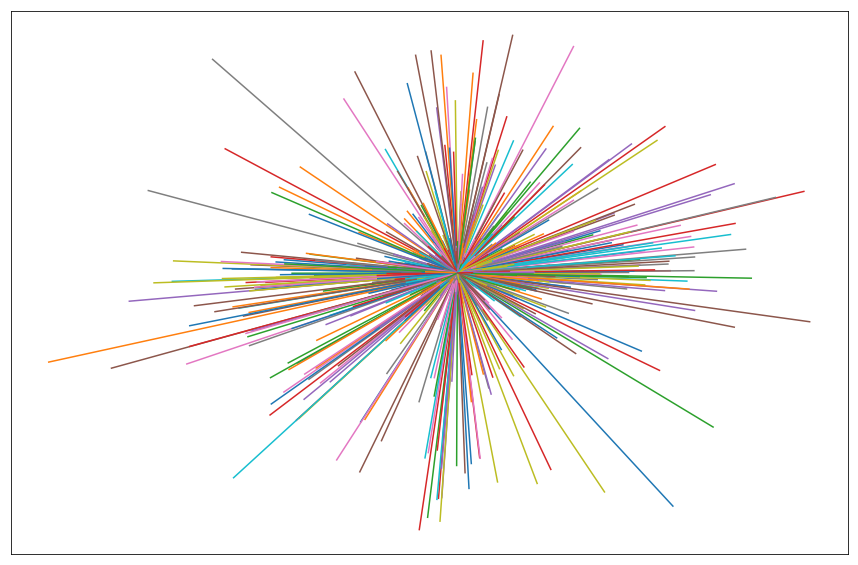

In [79]:
data = pd.read_csv('EyeMovementsGlaucomaDataset' + '/_suc_delta_' + 'C020.csv')
sac_coords = make_saccades_picture(data, save_pic=True)
sac_coords

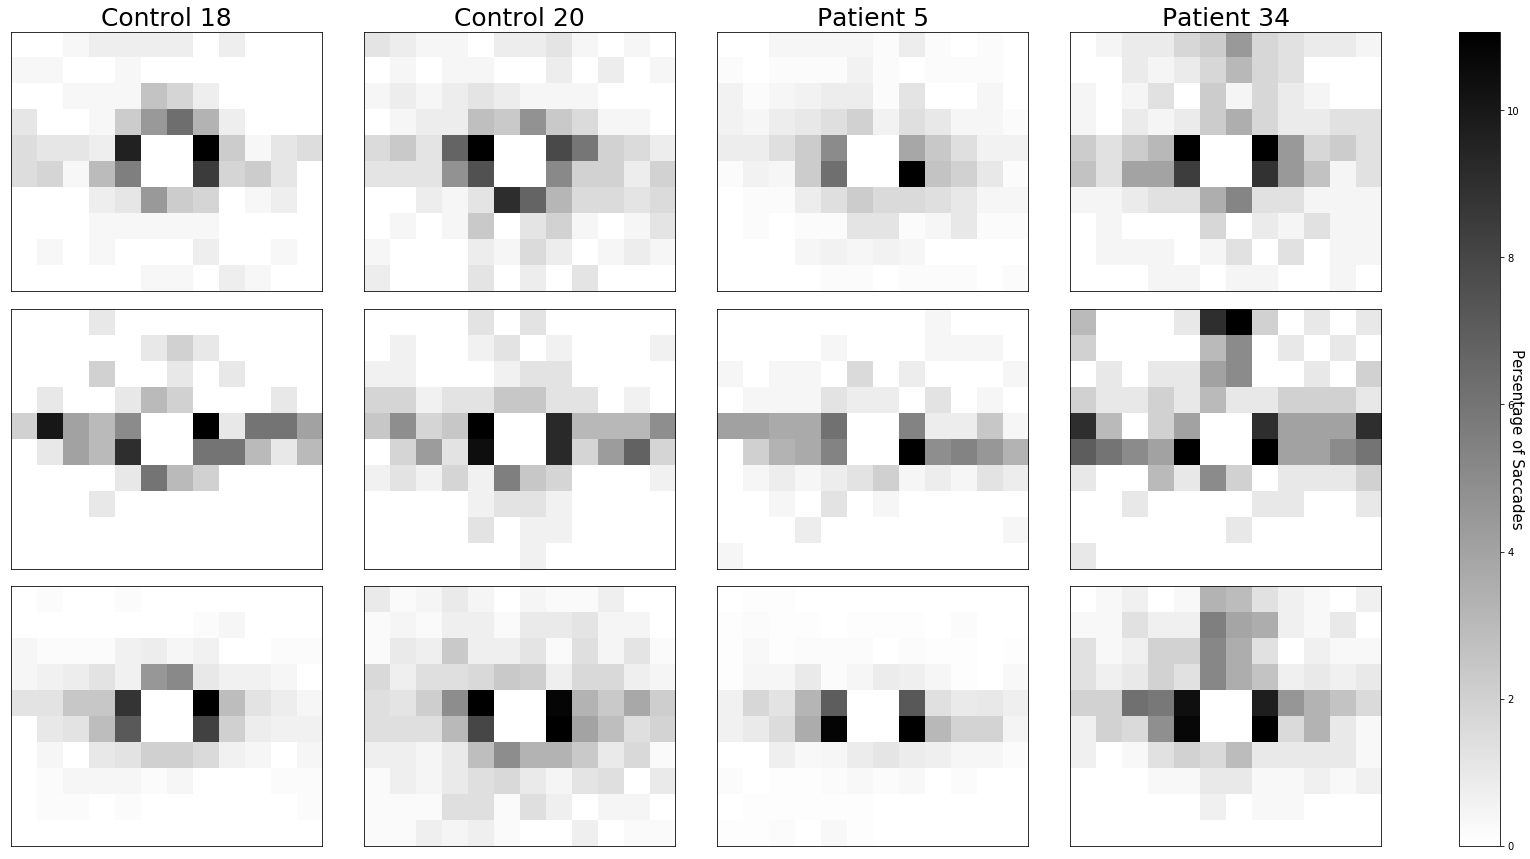

In [80]:
fig, axes = plt.subplots(3, 4, figsize=(22, 12))

axes[0, 0].imshow(den_maps_DA[17].reshape(10,12)*100, cmap = "binary")
axes[0, 0].set_title('Control 18', fontsize=25)
axes[0, 0].set_yticks(())
axes[0, 0].set_xticks(())
axes[1, 0].imshow(den_maps_HB[17].reshape(10,12)*100, cmap = "binary")
axes[1, 0].set_yticks(())
axes[1, 0].set_xticks(())
axes[2, 0].imshow(den_maps_SC[17].reshape(10,12)*100, cmap = "binary")
axes[2, 0].set_yticks(())
axes[2, 0].set_xticks(())

axes[0, 1].imshow(den_maps_DA[19].reshape(10,12)*100, cmap = "binary")
axes[0, 1].set_title('Control 20', fontsize=25)
axes[0, 1].set_yticks(())
axes[0, 1].set_xticks(())
heatmap=axes[1, 1].imshow(den_maps_HB[19].reshape(10,12)*100, cmap = "binary")
axes[1, 1].set_yticks(())
axes[1, 1].set_xticks(())
axes[2, 1].imshow(den_maps_SC[19].reshape(10,12)*100, cmap = "binary")
axes[2, 1].set_yticks(())
axes[2, 1].set_xticks(())

axes[0, 2].imshow(den_maps_DA[31 + 5].reshape(10,12)*100, cmap = "binary")
axes[0, 2].set_title('Patient 5', fontsize=25)
axes[0, 2].set_yticks(())
axes[0, 2].set_xticks(())
heatmap=axes[1, 2].imshow(den_maps_HB[31 + 5].reshape(10,12)*100, cmap = "binary")
axes[1, 2].set_yticks(())
axes[1, 2].set_xticks(())
axes[2, 2].imshow(den_maps_SC[31 + 5].reshape(10,12)*100, cmap = "binary")
axes[2, 2].set_yticks(())
axes[2, 2].set_xticks(())

axes[0, 3].imshow(den_maps_DA[63].reshape(10,12)*100, cmap = "binary")
axes[0, 3].set_title('Patient 34', fontsize=25)
axes[0, 3].set_yticks(())
axes[0, 3].set_xticks(())
axes[1, 3].imshow(den_maps_HB[63].reshape(10,12)*100, cmap = "binary")
axes[1, 3].set_yticks(())
axes[1, 3].set_xticks(())
axes[2, 3].imshow(den_maps_SC[63].reshape(10,12)*100, cmap = "binary")
axes[2, 3].set_yticks(())
axes[2, 3].set_xticks(())


fig.tight_layout()
cbar = fig.colorbar(heatmap, ax=axes, orientation='vertical', fraction=.035)
cbar.set_label('Persentage of Saccades', rotation=270, fontsize=15)
plt.savefig('Persentage_of_Saccades.png', dpi=200)

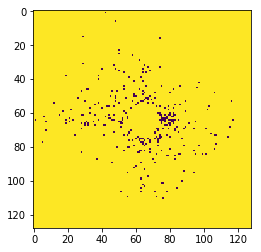

In [81]:
plt.imshow(pictures_DA[0])

In [15]:
K = make_kernel_matrix(make_data_for_kernel(den_maps_DA, den_maps_HB, den_maps_SC), np.array(den_maps_HB).shape[0])
K

array([[1.        , 0.52968724, 0.65212803, ..., 0.39199953, 0.31583179,
        0.52857896],
       [0.52968724, 1.        , 0.44390787, ..., 0.55175767, 0.2332205 ,
        0.48799798],
       [0.65212803, 0.44390787, 1.        , ..., 0.48187649, 0.30031302,
        0.6300126 ],
       ...,
       [0.39199953, 0.55175767, 0.48187649, ..., 1.        , 0.23592047,
        0.61076294],
       [0.31583179, 0.2332205 , 0.30031302, ..., 0.23592047, 1.        ,
        0.28445587],
       [0.52857896, 0.48799798, 0.6300126 , ..., 0.61076294, 0.28445587,
        1.        ]])

In [37]:
def center_kernel_matrix(K):
    K_center = K
    size = K.shape[0]
    K_center = K - K.sum(axis = 0).reshape(-1, 1)/size - K.sum(axis=1)/size + K.sum()/(size**2)
    K_diag = np.diag(K)
    return K_center/K_diag/K_diag.reshape(-1,1)

def centr_kernel_func(sample_1, sample_2, train_sample, K):
    K_12 = kernel_calc_func(sample_1, sample_2)
    K_1 = 0
    K_2 = 0
    for i in range(len(train_sample)):
        K_1 += kernel_calc_func(sample_1, train_sample[i])
        K_2 += kernel_calc_func(sample_2, train_sample[i]) 
    return K_12 - K_1/ len(train_sample) - K_2/ len(train_sample) + K.sum()/(len(train_sample)**2)
    
def get_projections(new_sample, train_samples, eigenvectors, K): 
    projections = []
    for eigen_idx in range(eigenvectors.shape[1]):
        projection = 0
        for element_idx, element in enumerate(train_samples):
            projection += eigenvectors[element_idx, eigen_idx] * centr_kernel_func(
                train_samples[element_idx], new_sample, train_samples, K)
        projections.append(projection)
    return np.asarray(projections)

In [17]:
center_kernel_matrix(K)

array([[ 0.50239569,  0.04430437,  0.12312684, ..., -0.08684336,
        -0.00258801, -0.01373694],
       [ 0.04430437,  0.52683857, -0.07287187, ...,  0.08513623,
        -0.07297786, -0.04209648],
       [ 0.12312684, -0.07287187,  0.43960194, ..., -0.02836327,
        -0.04950366,  0.05629983],
       ...,
       [-0.08684336,  0.08513623, -0.02836327, ...,  0.53991854,
        -0.0637379 ,  0.08720847],
       [-0.00258801, -0.07297786, -0.04950366, ..., -0.0637379 ,
         0.8607647 , -0.07867552],
       [-0.01373694, -0.04209648,  0.05629983, ...,  0.08720847,
        -0.07867552,  0.41297251]])

In [18]:
data_DA, data_HB, data_SC = den_maps_DA, den_maps_HB, den_maps_SC
data = make_data_for_kernel(data_DA, data_HB, data_SC)
data = np.array(data)
targets_p = np.array(targets_p)
n_components=5
K = make_kernel_matrix(make_data_for_kernel(den_maps_DA, den_maps_HB, den_maps_SC), np.array(den_maps_HB).shape[0])
eigenvalues, eigenvectors = linalg.eigh(center_kernel_matrix(K), 
                                        eigvals=(K.shape[0]-n_components, K.shape[0]-1))
for idx, eigenvalue in enumerate(eigenvalues):
    eigenvectors[:, idx] = eigenvectors[:, idx] / (np.linalg.norm(eigenvectors[:, idx], ord=2))

In [19]:
eigenvalues

array([1.83228622, 1.85838164, 2.02320103, 3.12585904, 4.20918908])

**Features in the new space:**

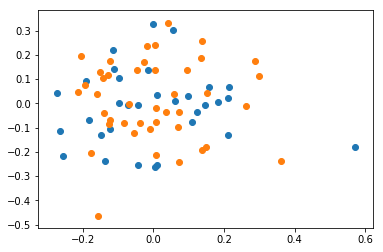

In [20]:
unt = 32
plt.scatter(eigenvectors[:,0][:unt]*np.sqrt(eigenvalues[0]), eigenvectors[:,1][:unt]*np.sqrt(eigenvalues[1]))
plt.scatter(eigenvectors[:,0][unt:]*np.sqrt(eigenvalues[0]), eigenvectors[:,1][unt:]*np.sqrt(eigenvalues[1]))

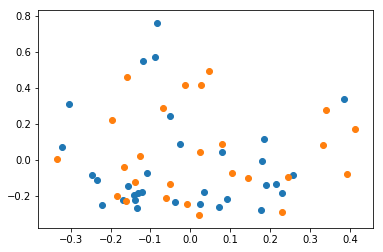

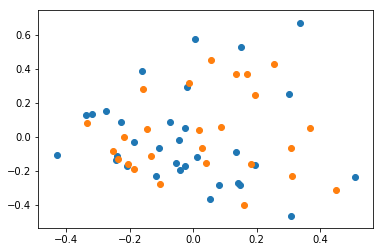

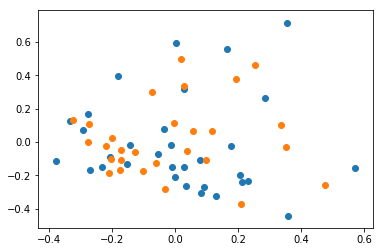

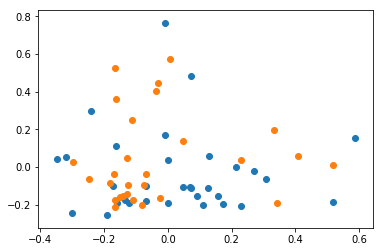

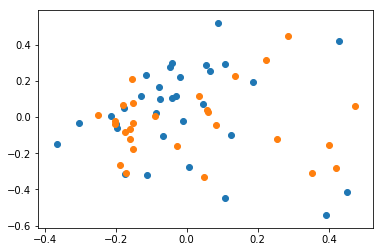

In [21]:
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=RANDOM_STATE)
scores = []
scores_train = []
data_DA, data_HB, data_SC = den_maps_DA, den_maps_HB, den_maps_SC
data = make_data_for_kernel(data_DA, data_HB, data_SC)
data = np.array(data)
targets_p = np.array(targets_p)
n_components=2
for train_index, test_index in skf.split(data, targets_p):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = targets_p[train_index], targets_p[test_index]
    K = make_kernel_matrix(X_train, len(train_index))
    eigenvalues, eigenvectors = linalg.eigh(center_kernel_matrix(K), 
                                            eigvals=(K.shape[0]-n_components, K.shape[0]-1))
    for idx, eigenvalue in enumerate(eigenvalues):
        eigenvectors[:, idx] = eigenvectors[:, idx] / (np.linalg.norm(eigenvectors[:, idx], ord=2))
    new_features_test = np.zeros((len(test_index), n_components))
    new_features_train = eigenvectors
    plt.scatter(eigenvectors[:,0][0:32]*np.sqrt(eigenvalues[0]), eigenvectors[:,1][0:32]*np.sqrt(eigenvalues[1]))
    plt.scatter(eigenvectors[:,0][32:]*np.sqrt(eigenvalues[0]), eigenvectors[:,1][32:]*np.sqrt(eigenvalues[1]))
    plt.show()
    for i in range(len(test_index)):
        new_features_test[i] = get_projections(X_test[i], X_train, eigenvectors, K)
    nb_clf = XGBClassifier()
    nb_clf.fit(new_features_train, y_train)
    score = accuracy_score(y_test, nb_clf.predict(new_features_test))
    score_train = accuracy_score(y_train, nb_clf.predict(eigenvectors))
    scores.append(score)
    scores_train.append(score_train)

In [22]:
print('Test scores:')
scores

Test scores:


[0.5625, 0.375, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429]

In [27]:
print('Train scores:')
scores_train

Train scores:


[0.896551724137931,
 0.9482758620689655,
 0.9333333333333333,
 0.9166666666666666,
 0.9]

**Now let's try kernel with pupil histograms**

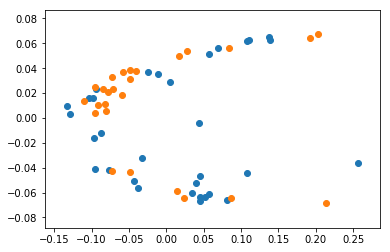

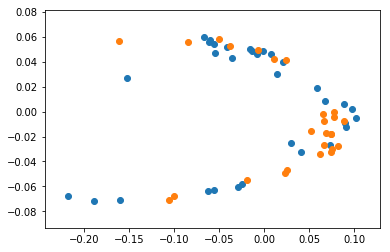

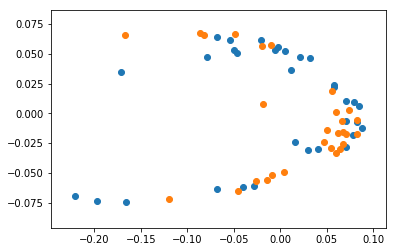

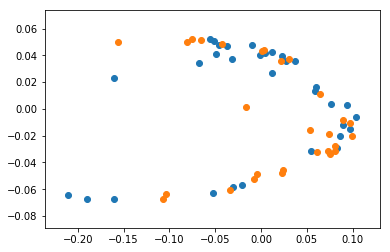

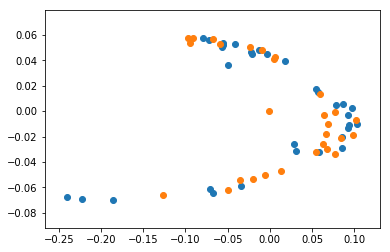

In [28]:
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=RANDOM_STATE)
scores = []
scores_train = []
data_DA, data_HB, data_SC = pupil_hists_DA, pupil_hists_HB, pupil_hists_SC
data = make_data_for_kernel(data_DA, data_HB, data_SC)
data = np.array(data)
targets_p = np.array(targets_p)
n_components = 2
for train_index, test_index in skf.split(data, targets_p):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = targets_p[train_index], targets_p[test_index]
    K = make_kernel_matrix(X_train, len(train_index))
    eigenvalues, eigenvectors = linalg.eigh(center_kernel_matrix(K), 
                                            eigvals=(K.shape[0]-n_components, K.shape[0]-1))
    for idx, eigenvalue in enumerate(eigenvalues):
        eigenvectors[:, idx] = eigenvectors[:, idx] / (eigenvalue * np.linalg.norm(eigenvectors[:, idx], ord=2))
    new_features_train = eigenvectors
    plt.scatter(eigenvectors[:,0][0:32]*np.sqrt(eigenvalues[0]), eigenvectors[:,1][0:32]*np.sqrt(eigenvalues[1]))
    plt.scatter(eigenvectors[:,0][32:]*np.sqrt(eigenvalues[0]), eigenvectors[:,1][32:]*np.sqrt(eigenvalues[1]))
    plt.show()
    new_features_test = np.zeros((len(test_index), n_components))
    for i in range(len(train_index)):
        new_features_train[i] = get_projections(X_train[i], X_train, eigenvectors, K)
    for i in range(len(test_index)):
        new_features_test[i] = get_projections(X_test[i], X_train, eigenvectors, K)
    nb_clf = XGBClassifier()
    nb_clf.fit(new_features_train, y_train)
    score = accuracy_score(y_test, nb_clf.predict(new_features_test))
    scores.append(score)
    score_train = accuracy_score(y_train, nb_clf.predict(new_features_train))
    scores_train.append(score_train)

In [29]:
print('Test scores:')
scores

Test scores:


[0.5625, 0.5625, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714]

In [30]:
print('Train scores:')
scores_train

Train scores:


[0.9655172413793104, 0.9655172413793104, 0.95, 0.95, 0.9666666666666667]

**Now let's compare our kernel pca methods with the sklearn's one.**

In [36]:
def kernel_func_one(x, y, sigma=0.2):
    return np.exp(-(x-y)**2/(2*sigma**2))

In [38]:
n_components = 2
sigma = 0.2
gamma = 1/(2*sigma**2)

data_DA, data_HB, data_SC = np.array(den_maps_DA).copy(), np.zeros(np.array(den_maps_HB).shape), np.zeros(np.array(den_maps_SC).shape)
data = np.array(make_data_for_kernel(data_DA, data_HB, data_SC))
K = make_kernel_matrix(make_data_for_kernel(den_maps_DA, den_maps_HB, den_maps_SC), np.array(den_maps_HB).shape[0])
eigenvalues, eigenvectors = linalg.eigh(center_kernel_matrix(K), 
                                        eigvals=(K.shape[0]-n_components, K.shape[0]-1))
for idx, eigenvalue in enumerate(eigenvalues):
    eigenvectors[:, idx] = eigenvectors[:, idx] / (np.linalg.norm(eigenvectors[:, idx], ord=2))
    
kpca = KernelPCA(n_components=n_components, kernel="rbf", fit_inverse_transform=True, gamma=gamma, random_state=RANDOM_STATE)
X_kpca = kpca.fit_transform(data_DA)


In [39]:
sklearn_kpca_eigenvalues = kpca.lambdas_
sklearn_kpca_eigenvalues

array([10.35032137,  1.62120677])

In [40]:
sklearn_kpca_eigenvectors = kpca.alphas_
sklearn_kpca_eigenvectors[:, 0]

array([-3.55315169e-02, -3.64202618e-02,  3.90368616e-01, -4.27997702e-02,
       -3.37853857e-02, -3.63476426e-02, -3.94228718e-02, -3.76549260e-02,
       -3.29424051e-02, -4.06662875e-02, -3.71093345e-02, -4.07061941e-02,
       -3.79755595e-02, -3.91123106e-02, -3.80233955e-02, -4.09972526e-02,
       -4.33967984e-02, -2.20444093e-02, -3.93150446e-02, -3.74284357e-02,
       -3.70857704e-02, -4.11850493e-02,  3.90368616e-01, -3.78879400e-02,
       -3.52396853e-02, -3.83514034e-02, -3.54987430e-02, -3.84459016e-02,
       -2.64169332e-02,  3.90368616e-01,  3.90368616e-01,  1.47604842e-03,
       -3.47999629e-02, -3.16166602e-02, -3.80609881e-02, -4.12748312e-02,
       -2.24744316e-02, -1.76211466e-02, -3.55303146e-02, -1.74801354e-04,
       -3.88384067e-02, -4.07549884e-02, -4.16075428e-02,  3.90368616e-01,
       -4.19048666e-02, -3.56964544e-02, -3.96855172e-02,  3.90368616e-01,
       -3.87729801e-02, -4.08755153e-02, -3.87687430e-02, -4.25789963e-02,
       -4.19296083e-02, -

In [41]:
eigenvalues

array([0.17717015, 0.34470103])

In [42]:
eigenvectors[:, 1]

array([-0.14617457,  0.09614598, -0.04534192,  0.15042479,  0.05820624,
        0.02679157, -0.00970834,  0.06093702, -0.00127653,  0.13171423,
        0.13157512, -0.04462932,  0.05923471,  0.0167151 ,  0.1507751 ,
       -0.020315  ,  0.08289176,  0.04130496,  0.18501708,  0.04224674,
       -0.28940357,  0.02812389, -0.04190127, -0.12589172,  0.09362927,
       -0.17005692, -0.04190127,  0.19155823,  0.04145935, -0.04190127,
       -0.04367693, -0.19283557,  0.01072335, -0.04399385,  0.10214892,
        0.11029526,  0.03112176,  0.16273399, -0.21277719,  0.02780228,
        0.14874158,  0.03568284,  0.03939101, -0.00107301,  0.01117299,
       -0.07361064,  0.03189026, -0.0451121 ,  0.02694487,  0.12095099,
        0.04636303,  0.12338753, -0.04784384, -0.18663502,  0.1101225 ,
       -0.04190127,  0.00301051, -0.02442445,  0.13242109,  0.08170239,
       -0.04190127, -0.03652252, -0.05295264, -0.02058595, -0.03023964,
       -0.07642518, -0.04623515, -0.02587269,  0.07312501, -0.43

In [43]:
kpca.alphas_[:,1] - eigenvectors[:,0]/np.sqrt(eigenvalues[0])

array([-0.32176125,  0.22901742,  0.12850447,  0.23682321, -0.41298224,
        0.04146629, -0.06591814,  0.05506276, -0.18097475,  0.07786571,
        0.35167009, -0.30523505, -0.09652243, -0.10669041, -0.53795517,
        0.6931244 ,  0.08635757, -0.31427527, -0.05802741,  0.20482275,
       -0.26152723, -0.48131312,  0.0994674 , -0.14387248,  0.1389816 ,
        0.05636038,  0.08494007, -0.4143381 , -0.20378187,  0.0994674 ,
        0.12364162, -0.1483946 ,  0.10053964,  0.0810276 , -0.50218538,
        0.26837003,  0.34520106,  1.67234777, -0.22289074,  0.14567432,
        0.07384457, -0.20395241, -0.21647485, -0.14471613, -0.49789422,
       -0.29301653, -0.08204608, -0.00524648, -0.03919672, -0.29068708,
        0.3239732 , -0.14705236, -0.26861163,  0.14740938,  0.06344577,
        0.12925817, -0.02034077,  0.36307288, -0.20998621,  0.10912638,
        0.26000724, -0.06251094, -0.06431404, -0.05364356,  0.12702265,
       -0.18843296, -0.01835448, -0.17975719,  0.4594303 , -0.03

**We also tried Convolutional Neural Network. However the number of training samples is too small so that our cnn cannot find complex dependencies.**

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))
if str(device) == 'cuda:0':
    print('Device name: {}'.format(torch.cuda.get_device_name(0)))

Device: cpu


In [97]:
class GlaucomaDataset(Dataset):
    """Data on Eye movements of Glaucoma Patients: a Case control Study"""

    def __init__(self, root_dir='EyeMovementsGlaucomaDataset', transform=None,
                 pictures_array=None, labels_array=None):
        """
        Args: 
            root_dir (string): Directory with all images.
        """
        self.pictures_array = pictures_array
        self.labels_array = labels_array
        self.transform = transform
        self.root_dir = root_dir
        self.pictures, self.labels = self._make_suc_delta_pictures()

    def __getitem__(self, idx):
        pic = np.asarray(self.pictures[idx])/255.
        pic = pic.astype(np.float64)
        pic = pic.reshape(pic.shape[0], pic.shape[1], 1)
        pic = Image.fromarray(np.asarray(self.pictures[idx]))
        if self.transform:
            pic = self.transform(pic)
        return pic, torch.tensor(self.labels[idx])
    
    def __len__(self):
        return len(self.labels)
    
    def _make_suc_delta_pictures(self):
        if self.pictures_array:
            return self.pictures_array, self.labels_array
        pictures = []
        labels = []
        size = 64
        for index, f in enumerate(files):
            if index == 60:
                break
            tempdata = pd.read_csv(self.root_dir + '/suc_delta/_suc_delta_' + f)
            if f[0] == 'C':
                labels.append(0)
            if f[0] == 'G':
                labels.append(1)
            pictures.append(255*np.ones((2*size, 2*size)))
            tempdata['delta X'] = (size - 1) * tempdata['delta X'] / max(tempdata['delta X'].max(), - tempdata['delta X'].min())
            tempdata['delta Y'] = (size - 1) * tempdata['delta Y'] / max(tempdata['delta Y'].max(), - tempdata['delta Y'].min())
            for i in range(tempdata.shape[0]):
                pictures[-1][size + int(tempdata['delta X'].iloc[i]), size + int(tempdata['delta Y'].iloc[i]) ] = 0
        return pictures, np.array(labels)
    
    def print_pic(self, idx):
        print(pictures[idx])
        return None
    

class GlaucomaDataset_Test(Dataset):
    """Data on Eye movements of Glaucoma Patients: a Case control Study"""

    def __init__(self, root_dir='EyeMovementsGlaucomaDataset', transform=None,
                pictures_array=None, labels_array=None):
        """
        Args: 
            root_dir (string): Directory with all images.
        """
        self.pictures_array = pictures_array
        self.labels_array = labels_array
        self.transform = transform
        self.root_dir = root_dir
        self.pictures, self.labels = self._make_suc_delta_pictures()
    
    def __getitem__(self, idx):
        pic = np.asarray(self.pictures[idx])/255.
        pic = pic.astype(np.float64)
        pic = pic.reshape(pic.shape[0], pic.shape[1], 1)
        pic = Image.fromarray(np.asarray(self.pictures[idx]))
        if self.transform:
            pic = self.transform(pic)
        return pic, torch.tensor(self.labels[idx])
    
    def __len__(self):
        return len(self.labels)
    
    def _make_suc_delta_pictures(self):
        if self.pictures_array:
            return self.pictures_array, self.labels_array
        pictures = []
        labels = []
        size = 64
        for index, f in enumerate(files):
            if index < 60:
                continue
            tempdata = pd.read_csv(self.root_dir + '/suc_delta/_suc_delta_' + f)
            if f[0] == 'C':
                labels.append(0)
            if f[0] == 'G':
                labels.append(1)
            pictures.append(255*np.ones((2*size, 2*size)))
            tempdata['delta X'] = (size - 1) * tempdata['delta X'] / max(tempdata['delta X'].max(), - tempdata['delta X'].min())
            tempdata['delta Y'] = (size - 1) * tempdata['delta Y'] / max(tempdata['delta Y'].max(), - tempdata['delta Y'].min())
            for i in range(tempdata.shape[0]):
                pictures[-1][size + int(tempdata['delta X'].iloc[i]), size + int(tempdata['delta Y'].iloc[i]) ] = 0
        return pictures, np.array(labels)
    
    def print_pic(self, idx):
        print(self.pictures[idx])
        return None
    
    
def set_random_seeds(seed_value=0, device=0):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def get_accuracy(model, dataloader, device=0):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)
    
def train(model, optimizer, train_size, train_loader, val_loader, batch_size, device, 
          scheduler=None, epochs_n=100, save_best=False):
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = (train_size - 1) // batch_size + 1

    for epoch in trange(epochs_n):
        if scheduler is not None:
            scheduler.step()
        model.train()

        learning_curve[epoch] = 0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            learning_curve[epoch] += loss.item()
            loss.backward()
            optimizer.step()

        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].set_title('Loss values')
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)
        
        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if save_best == True:
                torch.save(model.state_dict(), './best_params.pt')
        
        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve, label='Train')
        axes[1].plot(val_accuracy_curve, label='Validation')
        axes[1].legend()
        plt.tight_layout()
        plt.show()


class MyAwesomeNN(nn.Module):
    def __init__(self, inp_ch=1, outp_ch=2):
        super().__init__()
        self.stage1 = nn.Sequential(
            #!
            nn.Conv2d(in_channels=inp_ch, out_channels=5, kernel_size=9),
            nn.BatchNorm2d(5),
            nn.ReLU(),
            #!
            nn.MaxPool2d(kernel_size=2),
            #!
            nn.Conv2d(in_channels=5, out_channels=6, kernel_size=5),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            #!
            nn.MaxPool2d(kernel_size=4))
        
        self.stage2 = nn.Sequential(
            #!
            nn.Conv2d(in_channels=6, out_channels=5, kernel_size=5),
            nn.BatchNorm2d(5),
            nn.ReLU(),
            #!
            nn.MaxPool2d(kernel_size=2),
            #!
            nn.Conv2d(in_channels=5, out_channels=4, kernel_size=4),
            nn.BatchNorm2d(4),
            nn.ReLU())
            #!
            #nn.MaxPool2d(kernel_size=2))
        
        self.size = 2
        self.features = 30
        self.fc = nn.Sequential(
            nn.Linear(self.size*self.size*4, self.features),
            nn.ReLU(),
#            nn.Dropout(p=.65),
            nn.Linear(self.features, outp_ch))

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.fc(x.view(-1, self.size*self.size*4))
        return x

In [98]:
X_train, X_test, y_train, y_test = train_test_split(pictures_SC, targets_p, 
                                                    test_size=0.1, random_state=RANDOM_STATE)

set_random_seeds(device=device)
batch_size = 2
transform = transforms.Compose([transforms.ToTensor()])
dataset_train = GlaucomaDataset(transform=transform, pictures_array=X_train, labels_array=y_train)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataset_test = GlaucomaDataset_Test(transform=transform, pictures_array=X_test, labels_array=y_test)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

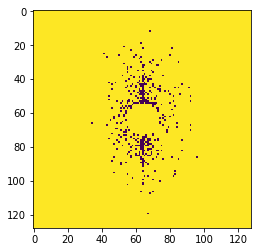

In [99]:
plt.imshow(np.array(X[0, 0, :, :]))

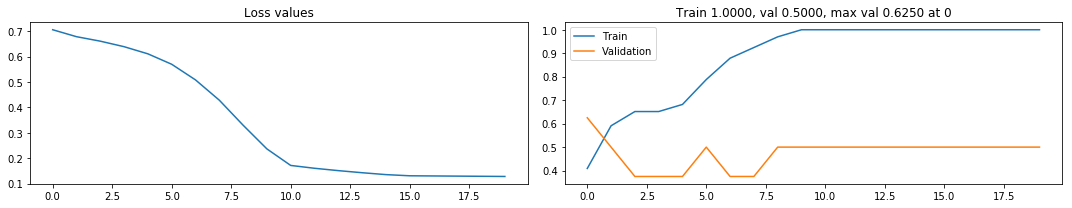



100%|██████████| 20/20 [00:22<00:00,  1.17s/it]



In [100]:
model = MyAwesomeNN().to(device)
adam_good_optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(adam_good_optimizer, (10, 15, ), gamma=.1)
train(model, adam_good_optimizer, train_size=len(dataset_train), train_loader=train_loader, val_loader=test_loader, 
      batch_size=batch_size, device=device, scheduler=scheduler, epochs_n=20, save_best=True)

In [37]:
model = MyAwesomeNN().to(device)
model.load_state_dict(torch.load('best_params.pt'))
model.eval()

train_accuracy = get_accuracy(model, train_loader, device)
test_accuracy = get_accuracy(model, test_loader, device)
print('train_accuracy = {}'.format(train_accuracy))
print('test_accuracy = {}'.format(test_accuracy))

train_accuracy = 0.6323529411764706
test_accuracy = 0.75
